# Connect Four DQN Training Visualization

This notebook trains a **Deep Q-Network (DQN)** agent to play Connect Four through self-play and visualizes the learning process.

## What is DQN?

DQN combines Q-learning with deep neural networks to handle large state spaces. Traditional Q-learning stores a value for every state-action pair in a table, but Connect Four has ~4.5 trillion possible states—far too many to store. Instead, DQN uses a neural network to *approximate* Q-values, learning patterns that generalize across similar positions.

## Key DQN Components

| Component | Purpose |
|-----------|---------|
| **Policy Network** | Predicts Q-values for actions; used to make decisions |
| **Target Network** | Provides stable training targets; updated periodically |
| **Replay Buffer** | Stores past experiences; random sampling breaks correlations |
| **Epsilon-Greedy** | Balances exploration (random moves) vs exploitation (best moves) |

## What to Expect

By the end of training, the agent should:
- Win 80-90% of games against a random opponent
- Show strategic play (blocking, setting up wins)
- Demonstrate first-player advantage (~60% P1 win rate in self-play)

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from game import ConnectFour, RandomAgent
from agent import DQNAgent

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Initialize the Agent

Create a DQN agent with carefully tuned hyperparameters. Each parameter significantly impacts learning:

| Parameter | Value | Purpose |
|-----------|-------|---------|
| `learning_rate` | 0.001 | How fast the network updates weights. Too high = unstable; too low = slow learning |
| `gamma` | 0.99 | Discount factor for future rewards. High value (close to 1) means the agent values long-term strategy |
| `epsilon_start` | 1.0 | Initial exploration rate (100% random moves at start) |
| `epsilon_end` | 0.01 | Final exploration rate (1% random moves when trained) |
| `epsilon_decay` | 0.9998 | Multiplicative decay per training step. Controls exploration→exploitation transition |
| `buffer_size` | 100,000 | Replay buffer capacity. Larger = more diverse training samples |
| `batch_size` | 64 | Samples per training step. Balances learning stability vs speed |
| `target_update_freq` | 1,000 | Steps between target network updates. Prevents "chasing a moving target" |

**Expected output:** Confirmation of device (CPU/CUDA) and initial epsilon of 1.0.

In [2]:
agent = DQNAgent(
    learning_rate=0.001,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.005,
    epsilon_decay=0.9998,
    buffer_size=100000,
    batch_size=64,
    target_update_freq=1000
)

print(f"Agent initialized")
print(f"Device: {agent.device}")
print(f"Initial epsilon: {agent.epsilon}")

DQN Agent using device: cpu
Agent initialized
Device: cpu
Initial epsilon: 1.0


## 2. Training Loop with Live Visualization

The agent learns through **self-play**: it plays both sides of every game, learning from wins and losses simultaneously.

### How Self-Play Training Works

1. **Play a game**: Agent chooses moves for both players using epsilon-greedy exploration
2. **Collect transitions**: Store each (state, action, next_state, done) tuple
3. **Assign rewards**: After game ends, assign +1 (win), -1 (loss), or 0 (draw) to each move
4. **Train on batch**: Sample random transitions from replay buffer and update network
5. **Decay epsilon**: Gradually shift from exploration to exploitation

### Why Self-Play?

- **No opponent needed**: Agent generates its own training data
- **Curriculum learning**: As agent improves, it faces stronger opposition automatically
- **Balanced training**: Sees positions from both winning and losing perspectives

### Metrics Tracked

| Metric | What it Shows |
|--------|---------------|
| P1/P2 Win Rate | Should stabilize ~60/40 due to first-player advantage |
| Draw Rate | Very low in Connect Four (game usually has a winner) |
| Epsilon | Decays per step, hits 0.01 floor around episode 400-500 |
| Avg Game Length | Typically 15-25 moves; longer games suggest defensive play |
| Loss | Training loss; should stabilize (not necessarily decrease) |

**Expected output:** Progress updates every 500 episodes showing win rates, epsilon, and loss.

In [ ]:
def train_with_stats(agent, num_episodes=10000, print_every=500):
    """Train agent and collect statistics."""
    stats = {
        'episode': [],
        'p1_win_rate': [],
        'p2_win_rate': [],
        'draw_rate': [],
        'epsilon': [],
        'avg_game_length': [],
        'avg_loss': []
    }
    
    # Rolling counters
    p1_wins = p2_wins = draws = total_moves = 0
    losses = []
    
    for episode in range(1, num_episodes + 1):
        game = ConnectFour()
        episode_transitions = []
        
        while not game.done:
            state = game.get_state()
            legal_actions = game.get_legal_actions()
            current_player = game.current_player
            
            # Pass current_player for correct state preprocessing
            action = agent.choose_action(state, legal_actions, training=True, current_player=current_player)
            next_state, reward, done = game.make_move(action)
            
            episode_transitions.append({
                'state': state,
                'action': action,
                'player': current_player,
                'next_state': next_state,
                'done': done
            })
        
        total_moves += game.move_count
        
        # Count game outcome ONCE per game (before transition loop)
        if game.winner == ConnectFour.PLAYER_1:
            p1_wins += 1
        elif game.winner == ConnectFour.PLAYER_2:
            p2_wins += 1
        else:
            draws += 1
        
        # Assign rewards to transitions (no counting here)
        for t in episode_transitions:
            if game.winner == t['player']:
                reward = 1.0
            elif game.winner is None:
                reward = 0.0
            else:
                reward = -1.0
            
            # Include player for correct perspective during training
            agent.store_transition(t['state'], t['action'], reward, t['next_state'], t['done'], t['player'])
            loss = agent.train_step()
            if loss is not None:
                losses.append(loss)
        
        agent.episodes_trained += 1
        
        # Record stats
        if episode % print_every == 0:
            total_games = p1_wins + p2_wins + draws
            if total_games > 0:
                stats['episode'].append(episode)
                stats['p1_win_rate'].append(p1_wins / total_games * 100)
                stats['p2_win_rate'].append(p2_wins / total_games * 100)
                stats['draw_rate'].append(draws / total_games * 100)
                stats['epsilon'].append(agent.epsilon)
                stats['avg_game_length'].append(total_moves / total_games)
                stats['avg_loss'].append(np.mean(losses) if losses else 0)
                
                print(f"Episode {episode:6d} | "
                      f"P1: {stats['p1_win_rate'][-1]:5.1f}% | "
                      f"P2: {stats['p2_win_rate'][-1]:5.1f}% | "
                      f"Draw: {stats['draw_rate'][-1]:5.1f}% | "
                      f"Eps: {agent.epsilon:.3f} | "
                      f"Loss: {stats['avg_loss'][-1]:.4f}")
            
            # Reset counters
            p1_wins = p2_wins = draws = total_moves = 0
            losses = []
    
    return stats

In [5]:
# Train the agent
NUM_EPISODES = 20000
PRINT_EVERY = 500

print(f"Training for {NUM_EPISODES} episodes...\n")
stats = train_with_stats(agent, num_episodes=NUM_EPISODES, print_every=PRINT_EVERY)
print("\nTraining complete!")

Training for 20000 episodes...

Episode    500 | P1:  54.4% | P2:  45.0% | Draw:   0.6% | Eps: 0.107 | Loss: 0.3489
Episode   1000 | P1:  52.4% | P2:  46.6% | Draw:   1.0% | Eps: 0.008 | Loss: 0.5213
Episode   1500 | P1:  51.2% | P2:  47.2% | Draw:   1.6% | Eps: 0.005 | Loss: 0.5430
Episode   2000 | P1:  50.2% | P2:  47.8% | Draw:   2.0% | Eps: 0.005 | Loss: 0.5110
Episode   2500 | P1:  48.6% | P2:  48.2% | Draw:   3.2% | Eps: 0.005 | Loss: 0.5378
Episode   3000 | P1:  49.2% | P2:  47.6% | Draw:   3.2% | Eps: 0.005 | Loss: 0.5729
Episode   3500 | P1:  54.0% | P2:  42.0% | Draw:   4.0% | Eps: 0.005 | Loss: 0.6191
Episode   4000 | P1:  55.6% | P2:  42.4% | Draw:   2.0% | Eps: 0.005 | Loss: 0.6091
Episode   4500 | P1:  53.2% | P2:  44.4% | Draw:   2.4% | Eps: 0.005 | Loss: 0.6312
Episode   5000 | P1:  52.8% | P2:  42.2% | Draw:   5.0% | Eps: 0.005 | Loss: 0.6506
Episode   5500 | P1:  53.8% | P2:  42.4% | Draw:   3.8% | Eps: 0.005 | Loss: 0.6581
Episode   6000 | P1:  58.4% | P2:  37.8% | D

## 3. Training Progress Visualization

These plots help diagnose whether training is proceeding correctly.

### How to Interpret Each Graph

**Top Left - Self-Play Outcomes:**
- Red (P1) should stabilize around 55-65% due to Connect Four's first-player advantage
- Gold (P2) should mirror P1 (what P1 wins, P2 loses)
- Gray (Draws) should be very low (<1%); Connect Four rarely ends in draws
- *If P1/P2 are both ~50%*: Agent may not be learning effectively

**Top Right - Epsilon Decay:**
- Starts at 1.0 (100% random exploration)
- Drops rapidly in first ~500 episodes (decays per *step*, not per episode)
- Flattens at 0.01 (1% exploration maintained for stability)
- *If decay is too slow*: Agent explores too long, wastes training time

**Bottom Left - Average Game Length:**
- Typical Connect Four games last 15-25 moves
- Red dashed line shows theoretical minimum (7 moves = fastest possible win)
- *If games are very short*: One side may be making obvious blunders
- *If games get longer over time*: Agent is learning defensive play

**Bottom Right - Training Loss:**
- Should stabilize but won't necessarily decrease (unlike supervised learning)
- Spikes are normal—occasional hard-to-predict positions
- *If loss explodes*: Learning rate may be too high

**Expected output:** Four subplots saved to `training_progress.png`.

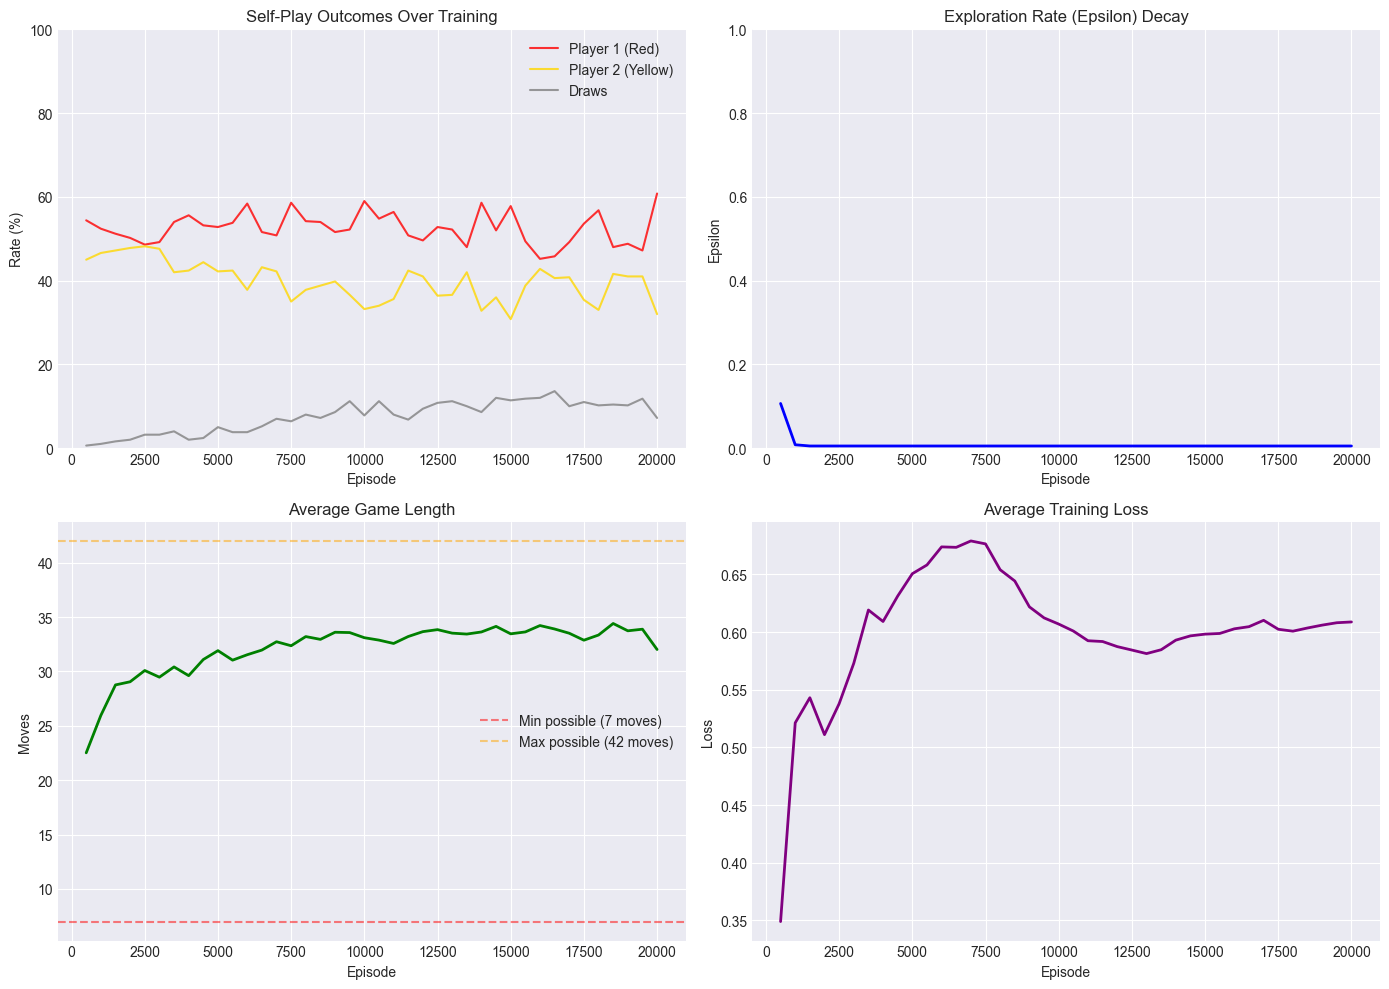

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Win/Loss/Draw rates
ax1 = axes[0, 0]
ax1.plot(stats['episode'], stats['p1_win_rate'], label='Player 1 (Red)', color='red', alpha=0.8)
ax1.plot(stats['episode'], stats['p2_win_rate'], label='Player 2 (Yellow)', color='gold', alpha=0.8)
ax1.plot(stats['episode'], stats['draw_rate'], label='Draws', color='gray', alpha=0.8)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Rate (%)')
ax1.set_title('Self-Play Outcomes Over Training')
ax1.legend()
ax1.set_ylim(0, 100)

# Epsilon decay
ax2 = axes[0, 1]
ax2.plot(stats['episode'], stats['epsilon'], color='blue', linewidth=2)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Epsilon')
ax2.set_title('Exploration Rate (Epsilon) Decay')
ax2.set_ylim(0, 1)

# Average game length
ax3 = axes[1, 0]
ax3.plot(stats['episode'], stats['avg_game_length'], color='green', linewidth=2)
ax3.set_xlabel('Episode')
ax3.set_ylabel('Moves')
ax3.set_title('Average Game Length')
ax3.axhline(y=7, color='red', linestyle='--', alpha=0.5, label='Min possible (7 moves)')
ax3.axhline(y=42, color='orange', linestyle='--', alpha=0.5, label='Max possible (42 moves)')
ax3.legend()

# Training loss
ax4 = axes[1, 1]
ax4.plot(stats['episode'], stats['avg_loss'], color='purple', linewidth=2)
ax4.set_xlabel('Episode')
ax4.set_ylabel('Loss')
ax4.set_title('Average Training Loss')

plt.tight_layout()
plt.savefig('../training_progress.png', dpi=150)
plt.show()

## 4. Evaluate Against Random Opponent

Self-play metrics don't tell us if the agent is actually *good*—just that one side wins more. To measure true skill, we benchmark against a **random opponent** that chooses uniformly from legal moves.

### Why Random Baseline?

- **Easy to implement**: No training required for opponent
- **Consistent benchmark**: Results are reproducible
- **Skill floor**: Any learning algorithm should easily beat random play
- **Baseline for comparison**: Future improvements can be measured against this

### What to Look For

| Metric | Poor | Good | Excellent |
|--------|------|------|-----------|
| Win rate vs Random | <70% | 80-90% | >95% |
| As P1 vs As P2 | Large gap | Similar | Very similar |

**As P1 (first player):** Agent should win more due to inherent first-player advantage.

**As P2 (second player):** Still should win majority; good defense can overcome P1 advantage against weak opponent.

**Expected output:** Win/loss/draw percentages for 500 games as P1 and 500 games as P2. A well-trained agent should win 80%+ in both roles.

In [ ]:
def evaluate_vs_random(agent, num_games=1000):
    """Evaluate agent against random opponent."""
    random_agent = RandomAgent()
    results = {'as_p1': {'wins': 0, 'losses': 0, 'draws': 0},
               'as_p2': {'wins': 0, 'losses': 0, 'draws': 0}}
    
    for game_num in range(num_games):
        game = ConnectFour()
        agent_is_p1 = (game_num % 2 == 0)
        key = 'as_p1' if agent_is_p1 else 'as_p2'
        
        while not game.done:
            state = game.get_state()
            legal = game.get_legal_actions()
            
            if (game.current_player == ConnectFour.PLAYER_1) == agent_is_p1:
                # Pass current_player for correct state preprocessing
                action = agent.choose_action(state, legal, training=False, current_player=game.current_player)
            else:
                action = random_agent.choose_action(state, legal)
            
            game.make_move(action)
        
        if game.winner is None:
            results[key]['draws'] += 1
        elif (game.winner == ConnectFour.PLAYER_1) == agent_is_p1:
            results[key]['wins'] += 1
        else:
            results[key]['losses'] += 1
    
    return results

print("Evaluating against random opponent (1000 games)...")
eval_results = evaluate_vs_random(agent, 1000)

print("\nResults:")
for role in ['as_p1', 'as_p2']:
    r = eval_results[role]
    total = r['wins'] + r['losses'] + r['draws']
    role_name = "As Player 1 (Red)" if role == 'as_p1' else "As Player 2 (Yellow)"
    print(f"\n{role_name}:")
    print(f"  Wins:   {r['wins']/total*100:5.1f}% ({r['wins']}/{total})")
    print(f"  Losses: {r['losses']/total*100:5.1f}% ({r['losses']}/{total})")
    print(f"  Draws:  {r['draws']/total*100:5.1f}% ({r['draws']}/{total})")

## 5. Visualize Agent's Decision Making

Peek inside the agent's "mind" by visualizing the Q-values it assigns to each possible move. This helps us understand *why* the agent chooses certain actions.

### What are Q-Values?

Q-values represent the agent's estimate of **expected future reward** for taking an action in a given state. Higher Q-value = agent believes this move leads to better outcomes.

```
Q(state, action) ≈ expected total reward if I take this action and play optimally afterward
```

### Reading the Visualization

**Left panel (Board):**
- Shows current game state
- Red = Player 1 pieces, Yellow = Player 2 pieces
- Indicates whose turn it is

**Right panel (Q-Values):**
- Bar height = Q-value for dropping piece in that column
- **Green bars** = Legal moves (column not full)
- **Red bars** = Illegal moves (column full)
- **Blue dashed line** = Agent's chosen action (highest Q among legal moves)

### What to Look For

- **Winning moves** should have highest Q-values (approaching +1)
- **Blocking moves** (preventing opponent win) should have high Q-values
- **Losing moves** should have low/negative Q-values
- **Illegal columns** may have any Q-value (agent learns to ignore them)

**Expected output:** Board visualization with corresponding Q-value bar chart showing the agent's evaluation of each column.

Current board:
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . Y Y . .
. . R R R . .
0 1 2 3 4 5 6



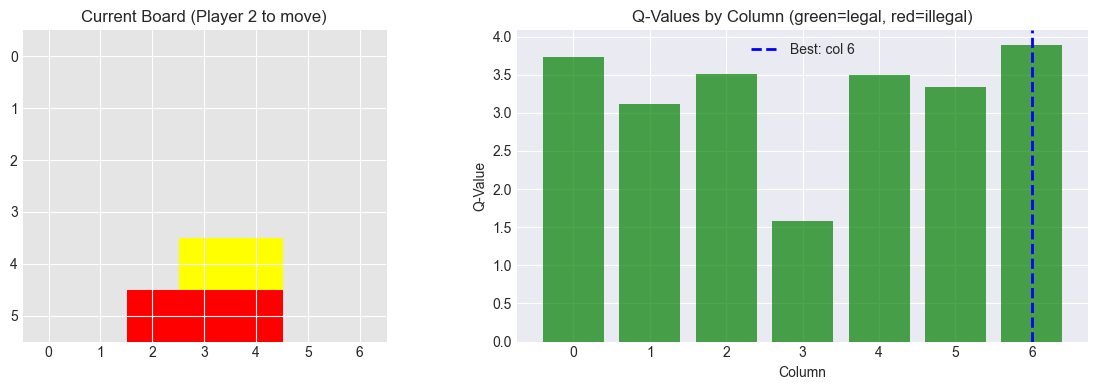

In [7]:
def visualize_q_values(agent, game):
    """Visualize Q-values for current board state."""
    state = game.get_state()
    legal_actions = game.get_legal_actions()
    
    # Get Q-values from network
    with torch.no_grad():
        state_tensor = agent._preprocess_state(state, game.current_player)
        q_values = agent.policy_net(state_tensor).cpu().numpy()[0]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Board visualization
    board_display = np.zeros((6, 7, 3))
    for r in range(6):
        for c in range(7):
            if state[r, c] == 1:
                board_display[r, c] = [1, 0, 0]  # Red
            elif state[r, c] == 2:
                board_display[r, c] = [1, 1, 0]  # Yellow
            else:
                board_display[r, c] = [0.9, 0.9, 0.9]  # Empty
    
    ax1.imshow(board_display)
    ax1.set_xticks(range(7))
    ax1.set_yticks(range(6))
    ax1.set_title(f'Current Board (Player {game.current_player} to move)')
    ax1.grid(True)
    
    # Q-values bar chart
    colors = ['green' if i in legal_actions else 'red' for i in range(7)]
    ax2.bar(range(7), q_values, color=colors, alpha=0.7)
    ax2.set_xlabel('Column')
    ax2.set_ylabel('Q-Value')
    ax2.set_title('Q-Values by Column (green=legal, red=illegal)')
    ax2.set_xticks(range(7))
    
    # Highlight best legal action
    best_action = max(legal_actions, key=lambda a: q_values[a])
    ax2.axvline(x=best_action, color='blue', linestyle='--', linewidth=2, label=f'Best: col {best_action}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Need torch import for visualization
import torch

# Create a sample game state
game = ConnectFour()
# Make some moves to create an interesting position
for col in [3, 3, 4, 4, 2]:
    if col in game.get_legal_actions():
        game.make_move(col)

print("Current board:")
print(game)
print()
visualize_q_values(agent, game)

## 6. Save Trained Agent

Save the trained neural network weights to disk for later use. This allows you to:

- **Play against the agent** using `python src/play.py`
- **Continue training** by loading weights and resuming
- **Compare versions** by saving checkpoints at different training stages
- **Deploy** the agent in other applications

### What Gets Saved

The `.pth` file (PyTorch format) contains:
- Policy network weights and architecture
- Target network weights
- Optimizer state (for resuming training)
- Training statistics (episodes, steps, epsilon)
- Replay buffer is **not** saved (would be very large)

### File Size

Expect ~2-5 MB for this architecture. The network has:
- ~500K parameters in convolutional layers
- ~100K parameters in fully connected layers

**Expected output:** Confirmation of save location and final training statistics including total episodes, training steps, final epsilon, and replay buffer size.

In [8]:
# Save the trained agent
agent.save('../trained_agent.pth')
print("Agent saved to ../trained_agent.pth")

# Print final stats
final_stats = agent.get_stats()
print(f"\nFinal Statistics:")
print(f"  Episodes trained: {final_stats['episodes']}")
print(f"  Training steps: {final_stats['training_steps']}")
print(f"  Final epsilon: {final_stats['epsilon']:.4f}")
print(f"  Replay buffer size: {final_stats['buffer_size']}")

Agent saved to ../trained_agent.pth
Agent saved to ../trained_agent.pth

Final Statistics:
  Episodes trained: 20000
  Training steps: 642353
  Final epsilon: 0.0050
  Replay buffer size: 100000
